In [89]:
import tensorflow as tf
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt

In [96]:
def pad_resize(image, height, width, h_c, w_c):
        """Summary
        
        Args:
            image (TYPE): Description
            height (TYPE): Description
            width (TYPE): Description
            scale (TYPE): Description
        
        Returns:
            numpy nd.array: Description
        """
        padded_image = np.zeros(shape=(height.astype(int), width.astype(int),3), dtype=image.dtype)
        h,w,_ =  image.shape
        padded_image[:h,:w,:] = image
        print(padded_image.shape)
        print(h_c, w_c)
#         resized_image = cv2.resize(padded_image, None).astype(tf.keras.backend.floatx())
        return padded_image

def try_f(image_batch, h, w, xmin, xmax, ymin, ymax, label):
    print(image_batch.shape, h, w)
    print(xmin, xmax, ymin,ymax, label)
    return image_batch

def try_mask(mask, height, width, label):
    mask = np.frombuffer(mask, dtype = 'bool')
    mask = mask.reshape((height, width, len(label)))
    print(mask.shape)
    return mask

@tf.function
def decode_pad_resize(image_string, pad_height, pad_width, height, width):
  """Summary

  Args:
      image_string (TYPE): Description
      pad_height (TYPE): Description
      pad_width (TYPE): Description
      scale (TYPE): Description

  Returns:
      tf.tensor: Description
  """
  image = tf.image.decode_jpeg(image_string)
  print(image.shape, height, width)
  print('haha')
  image = tf.numpy_function(pad_resize, [image, pad_height, pad_width, height, width], Tout=tf.uint8)
  #image.set_shape([None, None, 3])
  return image

def process_bboxes(image_array, bboxes, labels):

    # delete bboxes containing [-1,-1,-1,-1]
    bboxes = bboxes[~np.all(bboxes==-1, axis=1)]
    # delete labels containing[-1]
    labels = labels[labels>-1]#[0]

    # generate raw anchors
    raw_anchors = anchors_for_shape(
        image_shape=image_array.shape,
        sizes=sizes,
        ratios=ratios,
        scales=scales,
        strides=strides,
        pyramid_levels=[3, 4, 5, 6, 7],
        shapes_callback=None,
    )

    # generate anchorboxes and class labels      
    gt_regression, gt_classification = anchor_targets_bbox(
          anchors=raw_anchors,
          image=image_array,
          bboxes=bboxes,
          gt_labels=labels,
          num_classes=num_classes,
          negative_overlap=0.4,
          positive_overlap=0.5
      )

    return gt_regression, gt_classification

@tf.function
def tf_process_bboxes(xmin_batch, ymin_batch, xmax_batch, ymax_batch, label_batch, image_batch):

    regression_batch = list()
    classification_batch = list()

    for index in range(batch_size):
        xmins, ymins, xmaxs, ymaxs, labels = xmin_batch[index], ymin_batch[index], xmax_batch[index], ymax_batch[index], label_batch[index]
        image_array = image_batch[index]
        bboxes = tf.convert_to_tensor([xmins,ymins,xmaxs,ymaxs], dtype=tf.keras.backend.floatx())
        bboxes = tf.transpose(bboxes)
        gt_regression, gt_classification = tf.numpy_function(process_bboxes, [image_array, bboxes, labels], Tout=[tf.keras.backend.floatx(), tf.keras.backend.floatx()])

        regression_batch.append(gt_regression)
        classification_batch.append(gt_classification)

    return tf.convert_to_tensor(regression_batch), tf.convert_to_tensor(classification_batch)

    #return bboxes
    
def _annotate_and_save_image(img,mask):
    print("DEBUG")
#     print(image_path)
    img1 = np.zeros((img.shape[0], img.shape[1]))
#     print(img.shape)
    
    for i in range(mask.shape[2]):
        for j in range(img.shape[0]):
            for k in range(img.shape[1]):
                if(mask[j,k,i]):
                    img1[j,k] = 255
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(img1)

def hello(image, mask,xmin, xmax, ymin, ymax, label):
    print(image.shape, mask.shape,xmin, xmax, ymin, ymax, label.shape)
    _annotate_and_save_image(image, mask)
    return True

In [97]:
def _parse_function(serialized):
    """Summary

    Args:
        serialized (TYPE): Description

    Returns:
        TYPE: Description
    """
    features = {
      'image/height': tf.io.FixedLenFeature([], tf.int64),
      'image/width': tf.io.FixedLenFeature([], tf.int64),
      'image/encoded': tf.io.FixedLenFeature([],tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.keras.backend.floatx()),
      'image/f_id': tf.io.FixedLenFeature([], tf.int64),
      'image/object/class/label':tf.io.VarLenFeature(tf.int64),
      'image/object/mask': tf.io.FixedLenFeature([],tf.string)
    }


    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)

    max_height = tf.cast(tf.keras.backend.max(parsed_example['image/height']), tf.int32)
    max_width = tf.cast(tf.keras.backend.max(parsed_example['image/width']), tf.int32)
    image_batch = tf.image.decode_jpeg(parsed_example['image/encoded'])

    xmin = tf.sparse.to_dense(parsed_example['image/object/bbox/xmin'], default_value=-1)
    xmax = tf.sparse.to_dense(parsed_example['image/object/bbox/xmax'], default_value=-1)
    ymin = tf.sparse.to_dense(parsed_example['image/object/bbox/ymin'], default_value=-1)
    ymax = tf.sparse.to_dense(parsed_example['image/object/bbox/ymax'], default_value=-1)
    label = tf.sparse.to_dense(parsed_example['image/object/class/label'], default_value=-1)
    image_batch = tf.numpy_function(try_f, [image_batch, max_height, max_width, xmin, xmax, ymin, ymax, label], Tout=tf.uint8)
    mask = parsed_example['image/object/mask']
    mask = tf.numpy_function(try_mask, [mask, max_height, max_width, label], Tout = tf.bool)
    y = tf.numpy_function(hello, [image_batch, mask, xmin, xmax, ymin, ymax, label], Tout = tf.bool)
    return image_batch, {'out':label}


<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
(500, 375, 3) 500 375
[107.67   0.    95.32] [240.28 321.35 183.9 ] [292.54  86.52  32.31] [349.32 494.38  59.13] [21 49 53]
(500, 375, 3)
(500, 375, 3) (500, 375, 3) [107.67   0.    95.32] [240.28 321.35 183.9 ] [292.54  86.52  32.31] [349.32 494.38  59.13] (3,)
DEBUG
(<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[63, 37, 22],
        [64, 38, 23],
        [61, 38, 24],
        ...,
        [54, 49, 46],
        [56, 51, 48],
        [57, 52, 49]],

       [[63, 37, 22],
        [65, 39, 26],
        [62, 39, 25],
        ...,
        [56, 51, 47],
        [53, 48, 44],
        [53, 48, 45]],

       [[66, 40, 27],
        [62, 39, 25],
        [65, 42, 28],
        ...,
        [55, 52, 47],
        [56, 53, 48],
        [56, 52, 49]],

       ...,

       [[88, 56, 31],
        [88, 56, 33],
        [88, 53, 34],
        ...,
        [73, 43, 19],
        [74, 44, 20],
        [78, 46, 23]],

       [[87, 55

(<tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
array([[[  0,   5,   8],
        [  0,   5,   8],
        [  0,   4,   7],
        ...,
        [ 63, 101, 176],
        [ 53,  91, 166],
        [ 57,  93, 169]],

       [[  0,   6,   9],
        [  0,   6,   8],
        [  0,   5,   8],
        ...,
        [ 61,  98, 176],
        [ 60,  97, 175],
        [ 57,  93, 169]],

       [[  0,   5,   8],
        [  1,   6,   9],
        [  1,   6,   9],
        ...,
        [ 58,  96, 167],
        [ 55,  94, 163],
        [ 59,  98, 165]],

       ...,

       [[  0,   2,   1],
        [  0,   4,   3],
        [  1,   3,   2],
        ...,
        [ 89,  88,  84],
        [ 88,  87,  83],
        [ 88,  87,  83]],

       [[  0,   3,   2],
        [  0,   3,   2],
        [  1,   3,   2],
        ...,
        [ 91,  90,  86],
        [ 81,  77,  74],
        [ 95,  91,  88]],

       [[  0,   4,   3],
        [  0,   2,   1],
        [  0,   2,   1],
        ...,
        [ 83,  79,  

(<tf.Tensor: shape=(427, 640, 3), dtype=uint8, numpy=
array([[[ 95, 131, 167],
        [ 95, 131, 167],
        [ 97, 131, 168],
        ...,
        [103, 135, 174],
        [103, 135, 174],
        [103, 135, 174]],

       [[ 96, 132, 168],
        [ 97, 131, 168],
        [ 98, 132, 170],
        ...,
        [104, 136, 175],
        [104, 136, 175],
        [103, 137, 175]],

       [[ 98, 132, 169],
        [ 98, 132, 170],
        [100, 132, 171],
        ...,
        [105, 137, 176],
        [104, 136, 175],
        [104, 138, 176]],

       ...,

       [[225,  76,  44],
        [229,  78,  47],
        [230,  80,  47],
        ...,
        [139,  62,  46],
        [170,  94,  70],
        [188, 124,  89]],

       [[224,  83,  65],
        [229,  84,  67],
        [227,  85,  65],
        ...,
        [142,  65,  49],
        [167,  91,  67],
        [181, 117,  82]],

       [[220,  81,  76],
        [223,  81,  77],
        [219,  80,  73],
        ...,
        [144,  65,  

(<tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
array([[[  0,  10,   6],
        [  1,  17,   6],
        [  4,   7,   0],
        ...,
        [ 14,  39,   0],
        [ 14,  52,   3],
        [  6,  41,   1]],

       [[  0,  10,   2],
        [  7,  35,  20],
        [  0,  17,   2],
        ...,
        [  0,  22,   1],
        [ 15,  53,   0],
        [  5,  27,   6]],

       [[  3,   9,   0],
        [  7,  20,  10],
        [  0,  21,   6],
        ...,
        [  1,  20,   0],
        [  7,  34,   3],
        [  0,  29,   1]],

       ...,

       [[ 71,  55,  29],
        [ 76,  60,  34],
        [ 69,  53,  27],
        ...,
        [141, 119,  78],
        [118,  96,  55],
        [122,  99,  58]],

       [[ 65,  49,  23],
        [ 63,  47,  21],
        [ 57,  41,  15],
        ...,
        [156, 133,  91],
        [156, 135,  92],
        [138, 117,  74]],

       [[ 65,  49,  24],
        [ 59,  43,  18],
        [ 58,  44,  18],
        ...,
        [124, 101,  

/home/aniket.joshi/anaconda3/envs/cral/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(<tf.Tensor: shape=(426, 640, 3), dtype=uint8, numpy=
array([[[193, 189, 178],
        [191, 182, 183],
        [218, 206, 194],
        ...,
        [ 78,  83,  79],
        [115, 107,  88],
        [119, 102, 108]],

       [[191, 191, 181],
        [191, 189, 177],
        [211, 203, 192],
        ...,
        [ 75,  77,  74],
        [130, 121, 106],
        [ 81,  65,  75]],

       [[190, 192, 179],
        [191, 191, 179],
        [217, 212, 193],
        ...,
        [ 84,  85,  77],
        [141, 131, 122],
        [ 45,  31,  46]],

       ...,

       [[ 17,  36,  53],
        [ 17,  36,  51],
        [ 16,  35,  50],
        ...,
        [171, 152, 119],
        [164, 145, 112],
        [155, 136, 103]],

       [[ 18,  37,  54],
        [ 20,  39,  54],
        [ 16,  35,  50],
        ...,
        [162, 143, 110],
        [158, 139, 107],
        [157, 141, 108]],

       [[ 16,  35,  52],
        [ 19,  38,  53],
        [ 15,  34,  49],
        ...,
        [155, 136, 1

(<tf.Tensor: shape=(426, 640, 3), dtype=uint8, numpy=
array([[[  4,  11,   4],
        [  8,  11,   4],
        [  5,   6,   0],
        ...,
        [ 62,  44,  34],
        [ 65,  48,  38],
        [ 64,  52,  36]],

       [[  1,   6,   0],
        [  6,   9,   2],
        [  5,   6,   0],
        ...,
        [ 38,  19,  12],
        [ 46,  29,  21],
        [ 48,  34,  25]],

       [[  0,   5,   0],
        [  4,   6,   1],
        [  5,   6,   1],
        ...,
        [ 25,   5,   0],
        [ 25,   6,   0],
        [ 22,   7,   2]],

       ...,

       [[ 92, 184, 205],
        [109, 191, 202],
        [158, 216, 220],
        ...,
        [  1,   1,   1],
        [  3,   3,   3],
        [  4,   4,   4]],

       [[ 95, 168, 175],
        [114, 178, 187],
        [138, 211, 217],
        ...,
        [  0,   2,   0],
        [  6,   6,   4],
        [  3,   2,   0]],

       [[ 88, 167, 174],
        [123, 187, 197],
        [122, 199, 209],
        ...,
        [  0,   2,  

(<tf.Tensor: shape=(427, 640, 3), dtype=uint8, numpy=
array([[[243, 249, 247],
        [243, 250, 243],
        [245, 251, 247],
        ...,
        [247, 246, 241],
        [243, 243, 231],
        [237, 235, 236]],

       [[247, 253, 253],
        [244, 250, 246],
        [244, 250, 246],
        ...,
        [247, 246, 244],
        [243, 243, 233],
        [243, 242, 238]],

       [[245, 251, 251],
        [244, 250, 248],
        [243, 249, 245],
        ...,
        [244, 243, 238],
        [241, 241, 233],
        [244, 242, 245]],

       ...,

       [[ 67,  71,  54],
        [ 58,  68,  60],
        [ 46,  52,  42],
        ...,
        [ 94,  99,  93],
        [ 87,  92,  88],
        [ 87,  92,  86]],

       [[ 99, 106, 112],
        [ 87,  99, 113],
        [ 87,  96, 101],
        ...,
        [ 94,  99,  95],
        [ 89,  93,  94],
        [ 90,  94,  93]],

       [[ 99, 103, 102],
        [ 94, 105, 109],
        [ 74,  83,  78],
        ...,
        [ 94,  96,  

(<tf.Tensor: shape=(640, 427, 3), dtype=uint8, numpy=
array([[[175, 182, 210],
        [176, 181, 210],
        [177, 183, 209],
        ...,
        [158, 159, 177],
        [158, 159, 177],
        [158, 159, 177]],

       [[178, 183, 212],
        [177, 182, 211],
        [178, 184, 210],
        ...,
        [161, 160, 178],
        [161, 160, 178],
        [161, 160, 178]],

       [[177, 182, 211],
        [177, 182, 211],
        [177, 183, 209],
        ...,
        [162, 161, 179],
        [162, 161, 179],
        [162, 161, 179]],

       ...,

       [[125, 116, 111],
        [127, 118, 113],
        [129, 120, 115],
        ...,
        [139, 123,  87],
        [126, 110,  74],
        [129, 113,  77]],

       [[125, 116, 111],
        [126, 117, 112],
        [127, 118, 113],
        ...,
        [142, 126,  90],
        [130, 114,  78],
        [124, 108,  72]],

       [[126, 115, 111],
        [126, 115, 111],
        [126, 117, 112],
        ...,
        [147, 131,  

(<tf.Tensor: shape=(427, 640, 3), dtype=uint8, numpy=
array([[[ 68, 112, 137],
        [ 69, 113, 138],
        [ 71, 112, 140],
        ...,
        [ 96, 146, 169],
        [ 98, 149, 170],
        [ 97, 148, 169]],

       [[ 68, 112, 137],
        [ 68, 112, 137],
        [ 68, 112, 139],
        ...,
        [ 97, 148, 169],
        [ 98, 149, 170],
        [ 97, 148, 167]],

       [[ 67, 113, 137],
        [ 67, 113, 137],
        [ 68, 112, 137],
        ...,
        [ 98, 149, 170],
        [ 98, 149, 168],
        [ 97, 148, 167]],

       ...,

       [[ 65,  86,  71],
        [ 71,  92,  77],
        [ 70,  88,  74],
        ...,
        [ 70,  90,  78],
        [ 71,  91,  80],
        [ 71,  91,  82]],

       [[ 70,  91,  76],
        [ 74,  95,  80],
        [ 74,  92,  78],
        ...,
        [ 65,  85,  73],
        [ 66,  86,  75],
        [ 66,  86,  77]],

       [[ 70,  91,  76],
        [ 73,  94,  79],
        [ 73,  91,  77],
        ...,
        [ 64,  82,  

(<tf.Tensor: shape=(612, 612, 3), dtype=uint8, numpy=
array([[[107,  51,  26],
        [103,  47,  22],
        [106,  50,  23],
        ...,
        [ 19,  10,   5],
        [ 19,  10,   5],
        [ 19,  10,   5]],

       [[108,  52,  27],
        [ 99,  43,  18],
        [ 97,  41,  16],
        ...,
        [ 18,   9,   4],
        [ 18,   9,   4],
        [ 17,   8,   3]],

       [[105,  49,  26],
        [ 92,  36,  13],
        [ 91,  35,  12],
        ...,
        [ 16,   8,   5],
        [ 15,   7,   4],
        [ 13,   5,   2]],

       ...,

       [[124, 103,  56],
        [122, 104,  56],
        [122, 106,  57],
        ...,
        [210, 157, 107],
        [208, 155, 105],
        [208, 155, 105]],

       [[127, 106,  59],
        [122, 104,  56],
        [120, 104,  55],
        ...,
        [210, 157, 107],
        [209, 156, 106],
        [208, 155, 105]],

       [[128, 110,  64],
        [123, 105,  57],
        [119, 102,  56],
        ...,
        [209, 156, 1

(<tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
array([[[240, 240, 240],
        [240, 240, 240],
        [241, 241, 241],
        ...,
        [229, 231, 230],
        [229, 231, 230],
        [227, 229, 228]],

       [[240, 240, 240],
        [240, 240, 240],
        [241, 241, 241],
        ...,
        [229, 231, 230],
        [229, 231, 230],
        [228, 230, 229]],

       [[240, 240, 240],
        [241, 241, 241],
        [241, 241, 241],
        ...,
        [229, 231, 230],
        [229, 231, 230],
        [228, 230, 229]],

       ...,

       [[110, 106, 105],
        [108, 104, 103],
        [100,  96,  95],
        ...,
        [113, 109, 106],
        [111, 112, 107],
        [ 98, 101,  94]],

       [[106, 102, 101],
        [111, 107, 106],
        [111, 107, 106],
        ...,
        [102,  98,  95],
        [107, 108, 102],
        [116, 119, 112]],

       [[106, 102, 101],
        [104, 100,  99],
        [103,  99,  98],
        ...,
        [109, 108, 1

(<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[159, 174, 195],
        [158, 173, 194],
        [160, 175, 196],
        ...,
        [145, 157, 169],
        [145, 157, 169],
        [145, 159, 170]],

       [[155, 170, 191],
        [161, 176, 197],
        [167, 182, 203],
        ...,
        [147, 159, 171],
        [147, 159, 171],
        [147, 159, 171]],

       [[160, 175, 196],
        [162, 177, 198],
        [168, 183, 204],
        ...,
        [147, 159, 171],
        [148, 160, 172],
        [147, 159, 171]],

       ...,

       [[179, 172, 164],
        [185, 178, 170],
        [188, 179, 170],
        ...,
        [ 88, 112, 146],
        [ 89, 116, 143],
        [ 84, 112, 134]],

       [[160, 147, 139],
        [144, 131, 122],
        [128, 115, 106],
        ...,
        [ 85, 112, 142],
        [ 87, 114, 141],
        [ 79, 107, 129]],

       [[148, 130, 120],
        [151, 133, 123],
        [146, 128, 118],
        ...,
        [ 87, 113, 1

(<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[ 23,  22,  18],
        [ 23,  22,  18],
        [ 24,  23,  19],
        ...,
        [  9,  12,   5],
        [ 10,  12,   7],
        [ 10,  12,   7]],

       [[ 27,  26,  22],
        [ 28,  27,  23],
        [ 28,  27,  23],
        ...,
        [  8,   9,   4],
        [ 10,  11,   6],
        [ 11,  11,   9]],

       [[ 29,  28,  24],
        [ 29,  28,  24],
        [ 28,  27,  23],
        ...,
        [  9,   9,   7],
        [ 10,  10,  10],
        [ 12,  12,  12]],

       ...,

       [[164, 164, 136],
        [165, 165, 139],
        [166, 166, 142],
        ...,
        [158, 160, 146],
        [158, 160, 146],
        [158, 160, 146]],

       [[163, 163, 135],
        [164, 164, 138],
        [166, 166, 142],
        ...,
        [156, 158, 144],
        [156, 158, 144],
        [156, 158, 144]],

       [[164, 163, 135],
        [164, 162, 137],
        [166, 164, 141],
        ...,
        [155, 157, 1

(<tf.Tensor: shape=(640, 427, 3), dtype=uint8, numpy=
array([[[ 55,  43,  81],
        [ 52,  42,  76],
        [ 52,  43,  74],
        ...,
        [ 74,  85, 175],
        [ 74,  85, 174],
        [ 73,  84, 173]],

       [[ 52,  42,  77],
        [ 51,  41,  75],
        [ 52,  42,  76],
        ...,
        [ 67,  83, 171],
        [ 67,  83, 170],
        [ 66,  82, 169]],

       [[ 54,  43,  77],
        [ 52,  42,  76],
        [ 53,  43,  77],
        ...,
        [ 67,  84, 172],
        [ 66,  84, 170],
        [ 65,  83, 169]],

       ...,

       [[ 40,   1,   2],
        [ 40,   0,   0],
        [ 42,   0,   1],
        ...,
        [ 26,  17,  18],
        [ 27,  18,  19],
        [ 26,  17,  18]],

       [[ 37,   1,   1],
        [ 39,   1,   0],
        [ 41,   1,   1],
        ...,
        [ 26,  16,  17],
        [ 22,  13,  14],
        [ 23,  14,  15]],

       [[ 31,   0,   0],
        [ 35,   0,   0],
        [ 38,   0,   0],
        ...,
        [ 29,  19,  

(<tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
array([[[119, 112, 128],
        [123, 112, 129],
        [113, 123, 133],
        ...,
        [ 21,  33,  45],
        [ 29,  32,  47],
        [ 26,  40,  51]],

       [[145, 123, 136],
        [143, 143, 155],
        [106, 132, 147],
        ...,
        [ 53,  55,  52],
        [ 70,  51,  57],
        [ 81,  42,  63]],

       [[141, 162, 181],
        [121, 152, 170],
        [115, 136, 153],
        ...,
        [ 76,  91,  98],
        [110, 132, 130],
        [109, 108, 103]],

       ...,

       [[118, 116, 127],
        [118, 123, 116],
        [108, 117, 114],
        ...,
        [ 73,  71,  92],
        [ 58,  69,  65],
        [ 52,  64,  54]],

       [[129, 117, 119],
        [134, 129, 149],
        [133, 136, 143],
        ...,
        [ 58,  69,  61],
        [ 67,  73,  69],
        [ 68,  65,  74]],

       [[124, 124, 122],
        [124, 122, 125],
        [119, 101, 113],
        ...,
        [ 54,  64,  

(<tf.Tensor: shape=(426, 640, 3), dtype=uint8, numpy=
array([[[104, 112,  88],
        [101, 109,  85],
        [ 97, 105,  81],
        ...,
        [137, 123,  78],
        [135, 116,  73],
        [106, 103,  52]],

       [[103, 111,  87],
        [100, 108,  84],
        [ 96, 104,  80],
        ...,
        [ 81,  67,  20],
        [ 81,  63,  17],
        [ 74,  73,  19]],

       [[102, 110,  87],
        [100, 108,  85],
        [ 97, 105,  82],
        ...,
        [110,  96,  47],
        [112,  94,  44],
        [ 90,  87,  32]],

       ...,

       [[ 68,  65,  48],
        [ 68,  65,  48],
        [ 69,  66,  49],
        ...,
        [ 97,  76,  57],
        [ 96,  75,  58],
        [ 92,  70,  56]],

       [[ 68,  65,  48],
        [ 68,  65,  48],
        [ 70,  67,  50],
        ...,
        [ 96,  75,  58],
        [ 95,  74,  57],
        [ 95,  74,  57]],

       [[ 68,  65,  48],
        [ 68,  65,  48],
        [ 70,  67,  50],
        ...,
        [ 96,  75,  

(<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[ 85,  98,  45],
        [ 72,  79,  25],
        [ 87,  90,  33],
        ...,
        [126,  90,  66],
        [124,  93,  62],
        [113,  88,  48]],

       [[ 74,  76,  29],
        [ 68,  66,  18],
        [ 90,  87,  36],
        ...,
        [121,  90,  70],
        [120,  93,  64],
        [114,  90,  54]],

       [[ 60,  44,   8],
        [ 60,  45,   6],
        [ 94,  79,  36],
        ...,
        [112,  93,  79],
        [114,  93,  72],
        [113,  92,  65]],

       ...,

       [[155, 156, 150],
        [162, 162, 154],
        [169, 166, 159],
        ...,
        [130, 176, 103],
        [139, 186, 108],
        [151, 198, 117]],

       [[158, 159, 151],
        [160, 160, 152],
        [165, 162, 155],
        ...,
        [118, 171,  91],
        [124, 178,  94],
        [138, 192, 106]],

       [[155, 157, 146],
        [154, 154, 146],
        [158, 155, 148],
        ...,
        [116, 171,  

(<tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
array([[[140, 117,  73],
        [140, 116,  72],
        [141, 116,  75],
        ...,
        [172, 189, 170],
        [173, 190, 174],
        [174, 192, 176]],

       [[147, 121,  88],
        [143, 118,  78],
        [141, 118,  68],
        ...,
        [174, 191, 172],
        [175, 192, 174],
        [176, 195, 176]],

       [[150, 127,  77],
        [144, 120,  72],
        [141, 117,  69],
        ...,
        [177, 195, 173],
        [178, 196, 174],
        [179, 198, 176]],

       ...,

       [[ 17,  21,  24],
        [ 14,  18,  21],
        [ 16,  20,  23],
        ...,
        [ 28, 137, 108],
        [ 26, 140, 106],
        [ 26, 140, 104]],

       [[ 16,  20,  23],
        [ 14,  18,  21],
        [ 16,  20,  23],
        ...,
        [ 24, 132, 108],
        [ 26, 139, 111],
        [ 30, 144, 111]],

       [[ 15,  19,  20],
        [ 13,  17,  18],
        [ 15,  19,  20],
        ...,
        [ 21, 130, 1

(480, 640, 3) (480, 640, 18) [ 90.2   21.65 120.44  80.52 152.45  49.17 351.99 372.48 242.65 182.11
 387.99 499.24 202.08 240.29  12.93 584.06 588.7    0.  ] [568.05  54.49 157.39 119.98 197.77  95.09 378.41 397.58 276.64 202.47
 417.56 518.42 234.66 263.97  53.39 603.96 606.18 639.  ] [ 68.88  35.31   9.58  62.07  22.41  70.74  69.57  62.2   75.97  61.2
  78.79 107.99  50.18  64.25 113.37 143.88 105.57   0.  ] [446.86 111.35  91.16 178.16 103.91 188.1  108.56 106.37 117.71 102.08
 163.58 161.97 101.35  88.4  150.61 169.46 138.06 355.  ] (18,)
DEBUG
(<tf.Tensor: shape=(480, 640, 3), dtype=uint8, numpy=
array([[[ 99,  64,  26],
        [111,  89,  48],
        [ 94,  83,  53],
        ...,
        [105,  49,  26],
        [ 96,  41,  21],
        [102,  58,  33]],

       [[ 92,  62,  36],
        [101,  86,  55],
        [ 90,  82,  61],
        ...,
        [100,  49,  30],
        [ 91,  42,  25],
        [ 97,  55,  33]],

       [[ 85,  60,  29],
        [ 89,  79,  43],
        [ 

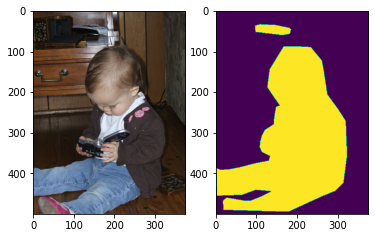

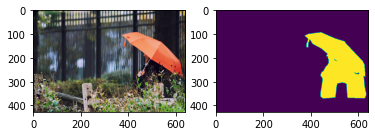

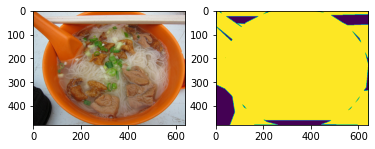

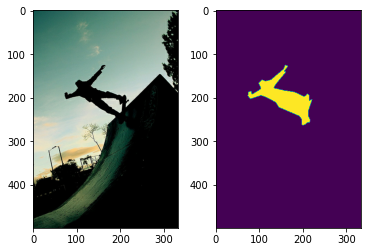

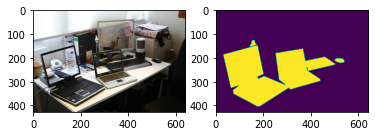

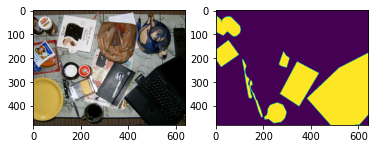

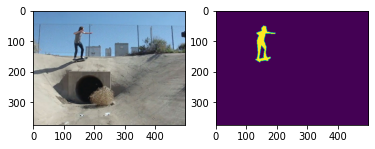

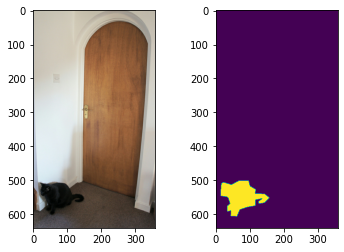

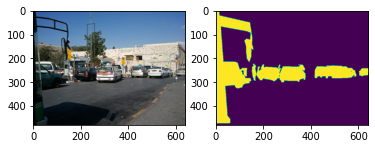

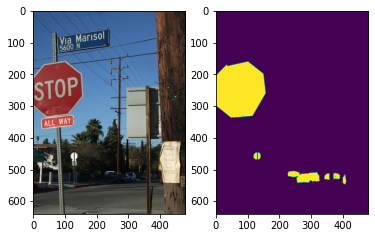

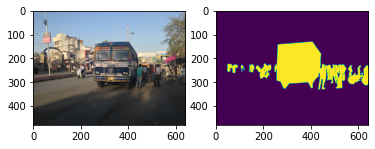

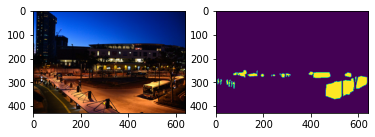

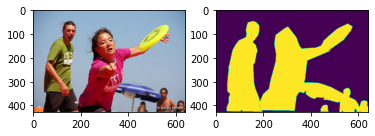

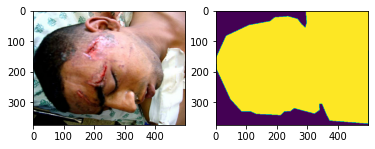

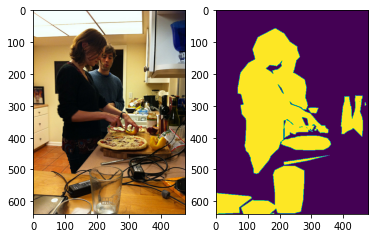

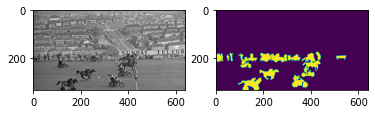

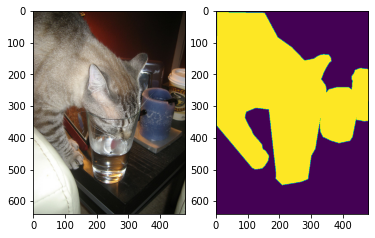

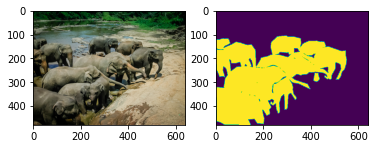

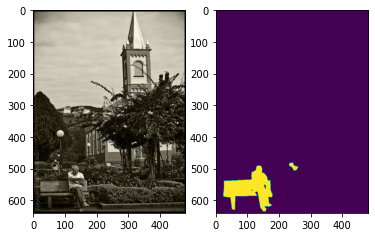

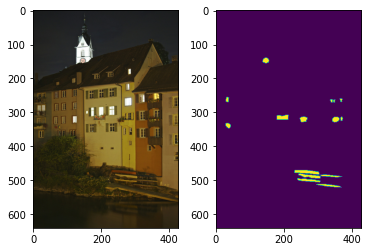

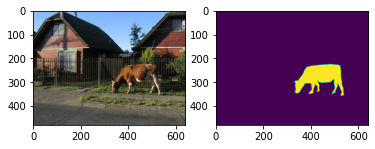

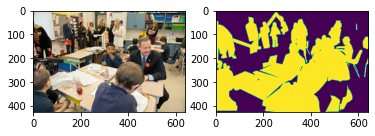

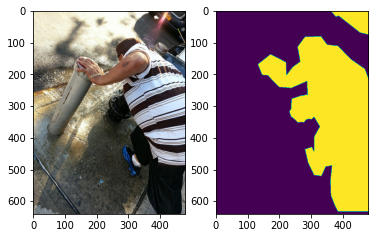

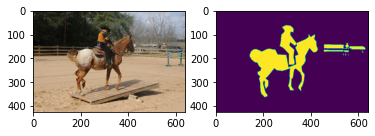

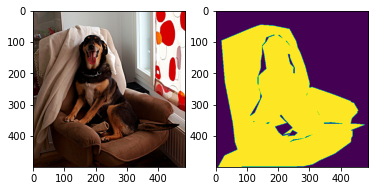

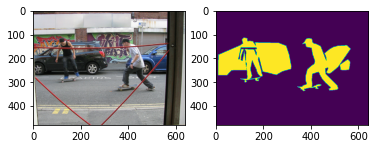

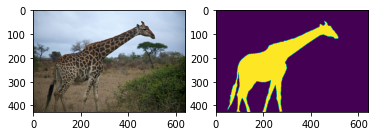

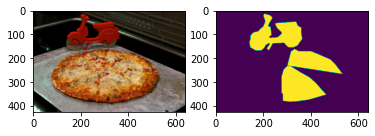

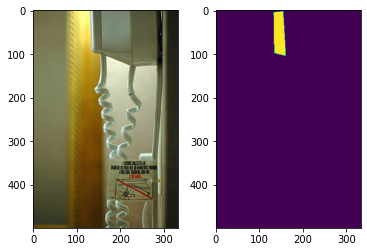

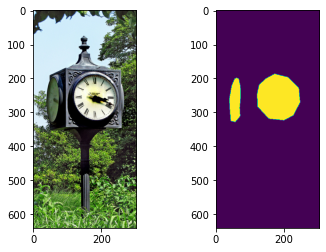

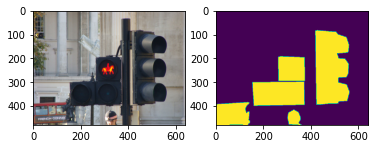

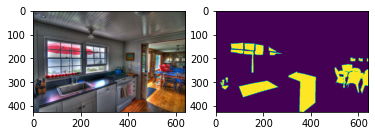

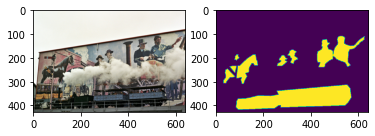

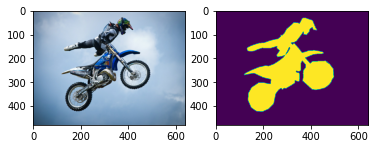

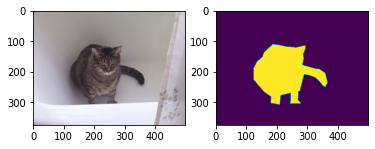

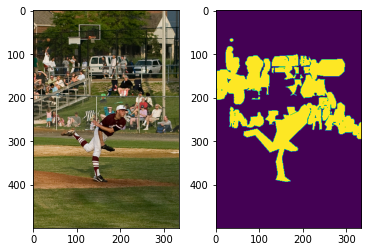

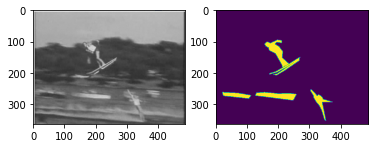

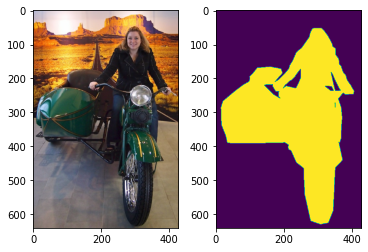

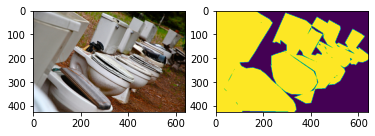

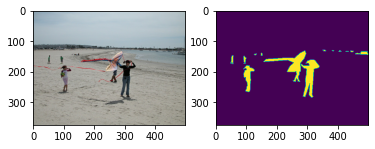

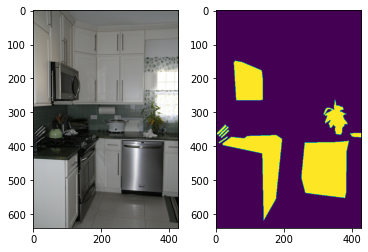

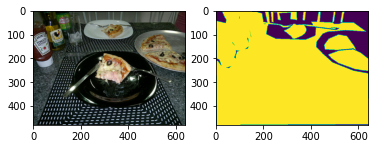

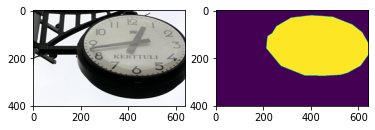

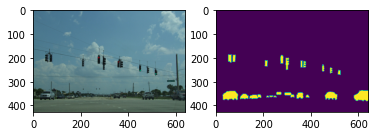

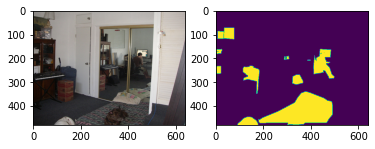

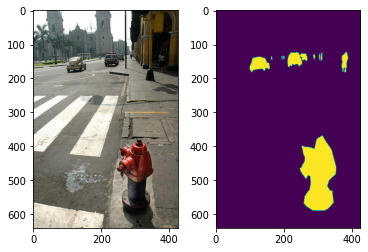

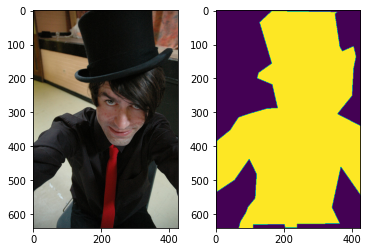

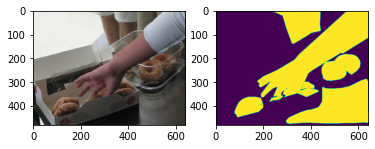

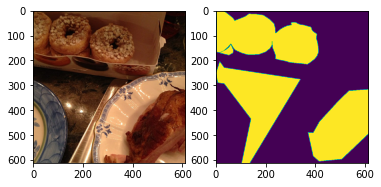

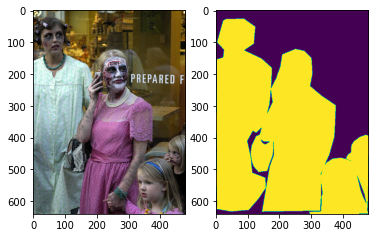

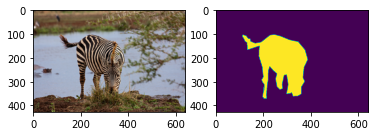

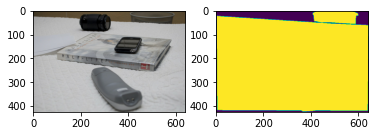

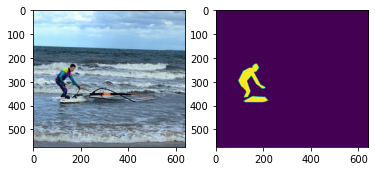

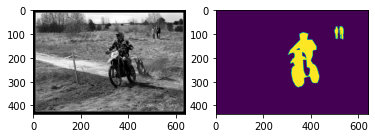

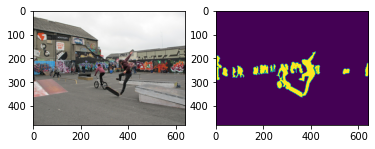

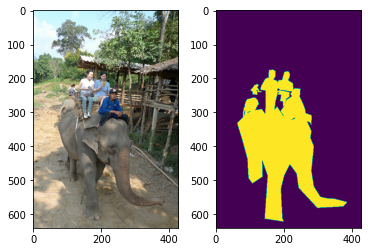

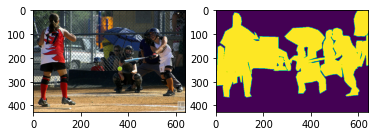

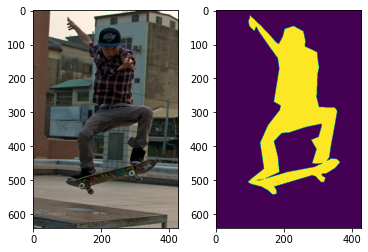

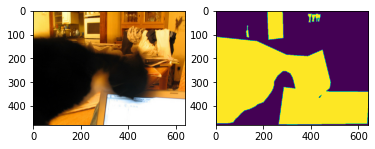

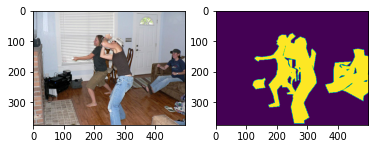

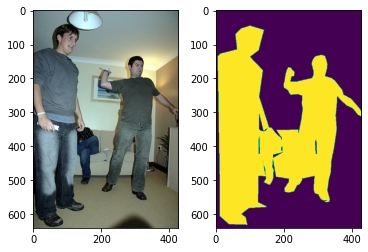

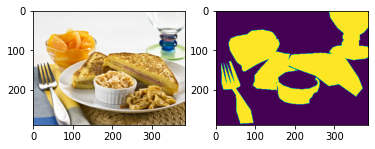

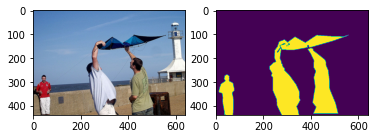

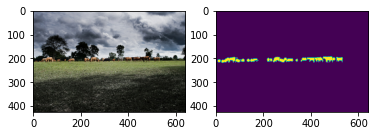

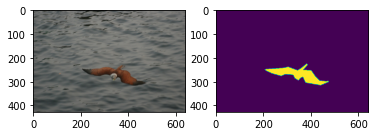

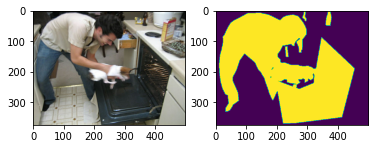

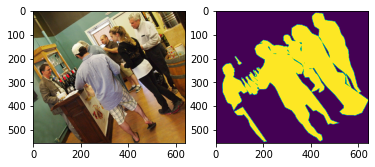

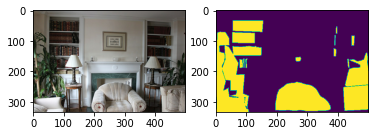

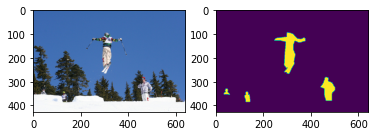

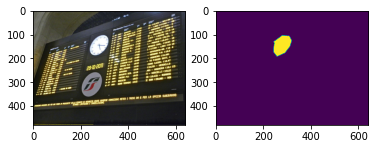

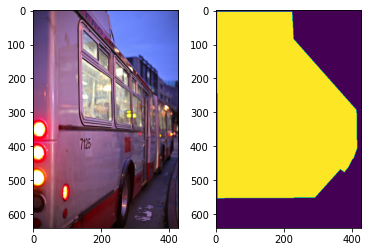

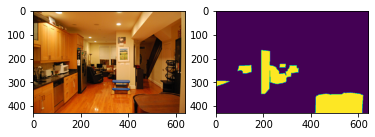

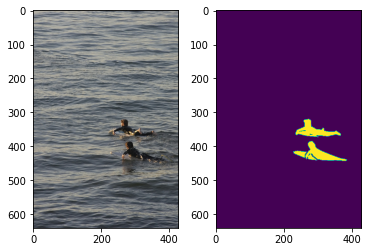

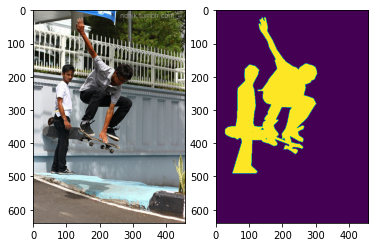

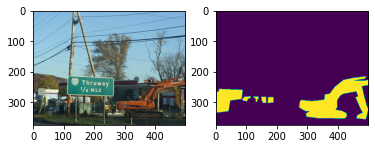

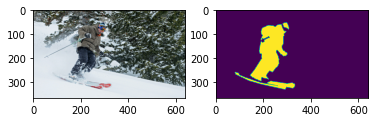

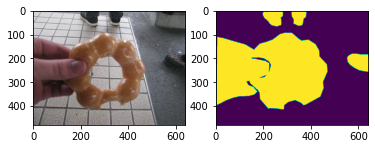

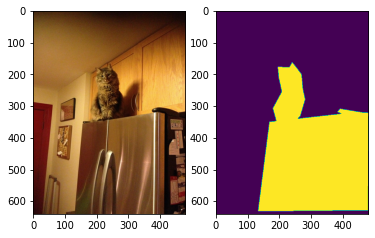

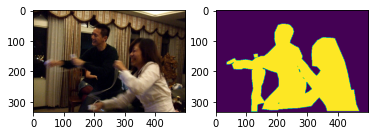

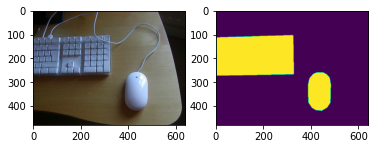

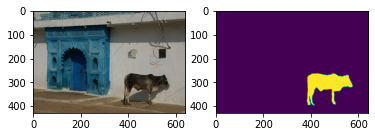

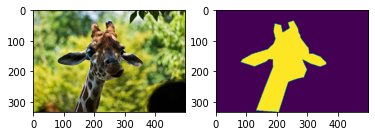

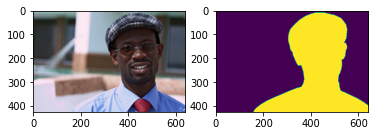

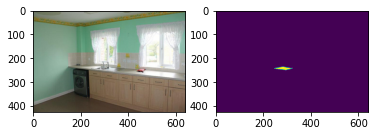

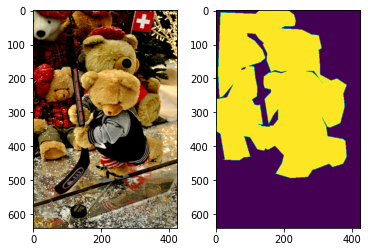

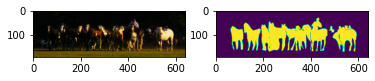

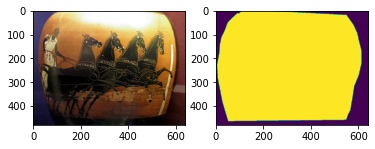

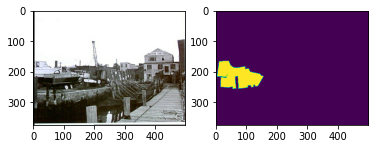

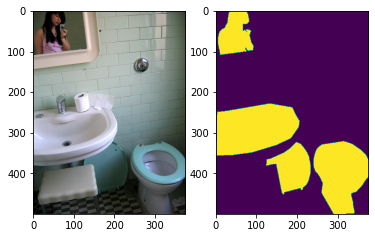

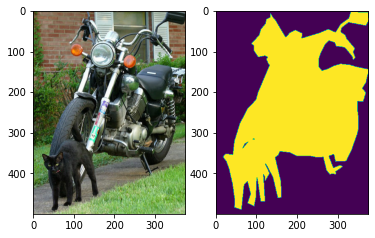

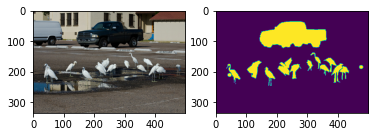

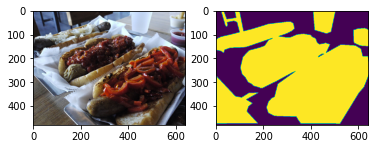

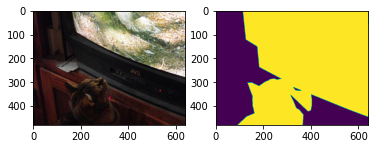

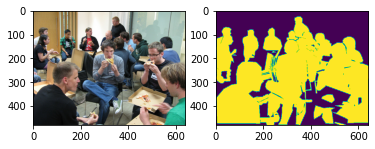

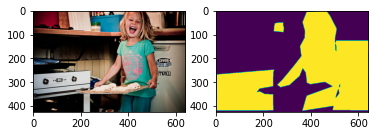

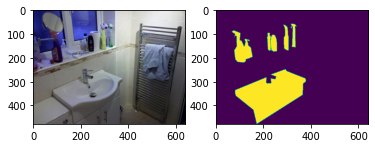

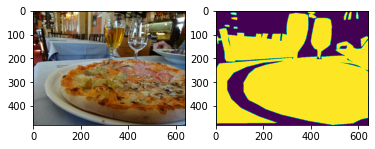

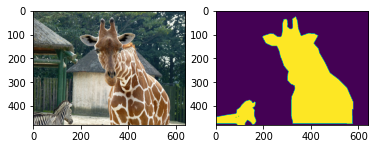

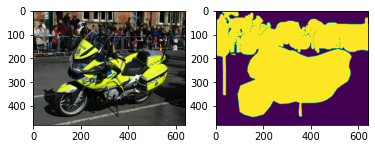

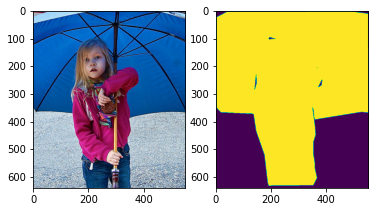

In [99]:
train_tfrecords = glob.glob('/tmp/*.tfrecord')
dataset = tf.data.TFRecordDataset(train_tfrecords)
# dataset = dataset.batch(8, drop_remainder=True)
dataset = dataset.map(_parse_function)
print(type(dataset))
for image_data in dataset.take(100):
    print(image_data)